# Make sound files WITH GW150914 OPEN DATA 

Make wav (sound) files from the filtered, downsampled data, +-2s around the event.

In [1]:
# make wav (sound) files from the whitened data, +-2s around the event.
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio, display_html

# function to keep the data within integer limits, and write to wavfile:
def write_wavfile(filename, fs, data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename, int(fs), d)
    display_html(Audio(filename))

tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 2.                     # seconds around the event

# index into the strain time series for this time interval:
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

# write the files:
write_wavfile("GW150914_H1_whitenbp.wav",int(fs), strain_H1_whitenbp[indxt])
write_wavfile("GW150914_L1_whitenbp.wav",int(fs), strain_L1_whitenbp[indxt])
write_wavfile("GW150914_NR_whitenbp.wav",int(fs), NR_H1_whitenbp)


NameError: name 'time' is not defined

With good headphones, you'll hear a faint thump in the middle.

We can enhance this by increasing the frequency; 
this is the "audio" equivalent of the enhanced visuals that NASA employs on telescope images with "false color".

The code below will shift the data up by 400 Hz (by taking an FFT, shifting/rolling the frequency series, then inverse fft-ing). The resulting sound file will be noticibly more high-pitched, and the signal will be easier to hear.

In [3]:
# function that shifts frequency of a band-passed signal
def reqshift(data,fshift=100,sample_rate=4096):
    """Frequency shift the signal by constant
    """
    x = np.fft.rfft(data)
    T = len(data)/float(sample_rate)
    df = 1.0/T
    nbins = int(fshift/df)
    # print T,df,nbins,x.real.shape
    y = np.roll(x.real,nbins) + 1j*np.roll(x.imag,nbins)
    z = np.fft.irfft(y)
    return z

# parameters for frequency shift
fs = 4096
fshift = 400.
speedup = 1.
fss = int(float(fs)*float(speedup))

# shift frequency of the data
strain_H1_shifted = reqshift(strain_H1_whitenbp,fshift=fshift,sample_rate=fs)
strain_L1_shifted = reqshift(strain_L1_whitenbp,fshift=fshift,sample_rate=fs)
NR_H1_shifted = reqshift(NR_H1_whitenbp,fshift=fshift,sample_rate=fs)

# write the files:
write_wavfile("GW150914_H1_shifted.wav",int(fs), strain_H1_shifted[indxt])
write_wavfile("GW150914_L1_shifted.wav",int(fs), strain_L1_shifted[indxt])
write_wavfile("GW150914_NR_shifted.wav",int(fs), NR_H1_shifted)


NameError: name 'strain_H1_whitenbp' is not defined

## Downsampling from 16384 Hz to 4096 Hz

So far, we have been working with data sampled at fs=4096 Hz. This is entirely sufficient for signals with no frequency content above f_Nyquist = fs/2 = 2048 Hz, such as GW150914. 

We downsample to 4096 Hz to save on download time, disk space, and memory requirements. If, however, you are interested in signals with frequency content above 2048 Hz, you need the data sampled at the full rate of 16384 Hz. 

Here we demonstrate how to do that downsampling, and how it might limit you is you are interested in frequency content near 2048 Hz and above.

First, download a LOSC data file containing 32 seconds of data at the full 16384 Hz rate, and another downsampled at 4096 Hs, and put them in your working directory / folder:
* https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126259446-32.hdf5
* https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126259446-32.hdf5

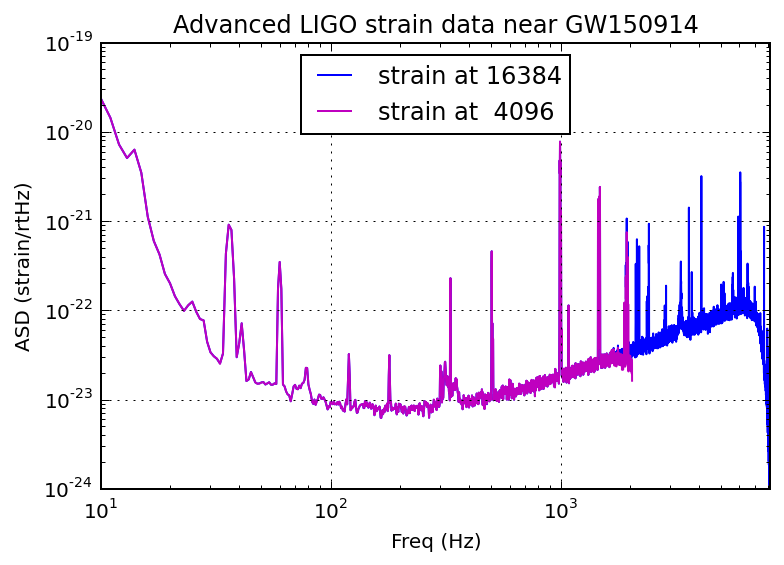

In [17]:
# read in the data at 16384 Hz and at 4096 Hz:
fn_16 = 'H-H1_LOSC_16_V1-1126259446-32.hdf5'
strain_16, time_16, chan_dict = rl.loaddata(fn_16, 'H1')
fn_4 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_4, time_4, chan_dict = rl.loaddata(fn_4, 'H1')

# Make PSDs of each:
fs = 16384
NFFT = 1*fs
Pxx_16, freqs_16 = mlab.psd(strain_16, Fs = fs, NFFT = NFFT)

fs = 4096
NFFT = 1*fs
Pxx_4, freqs_4 = mlab.psd(strain_4, Fs = fs, NFFT = NFFT)

fmin = 10
fmax = 8192

plt.figure()
plt.loglog(freqs_16, np.sqrt(Pxx_16),'b',label='strain at 16384')
plt.loglog(freqs_4,  np.sqrt(Pxx_4), 'm',label='strain at  4096')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_H1_ASD_16384.png')


Good agreement between 16384 Hz data and 4096 Hz data,
up to around f_Nyquist = 2048 Hz. Let's zoom in for a closer look:

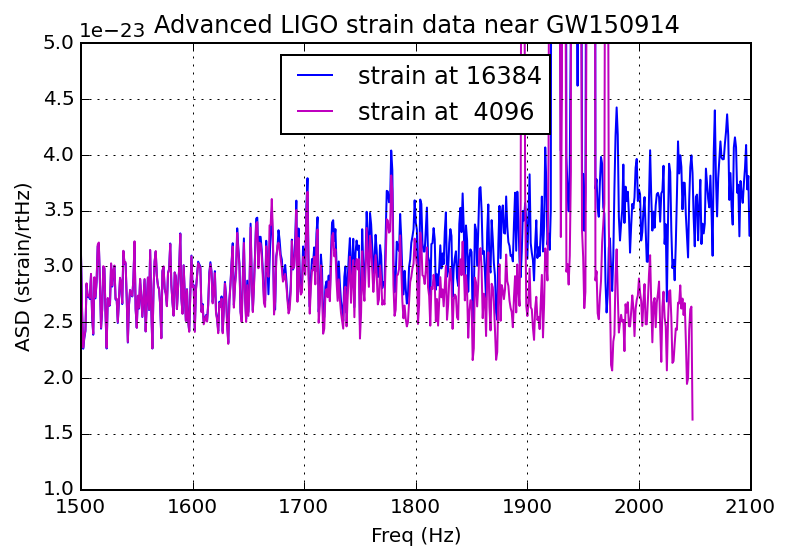

In [18]:
# Zoom in on the 1000-2000 Hz region:
fmin = 1500
fmax = 2100

plt.figure()
plt.plot(freqs_16, np.sqrt(Pxx_16),'b',label='strain at 16384')
plt.plot(freqs_4,  np.sqrt(Pxx_4), 'm',label='strain at  4096')
plt.axis([fmin, fmax, 1e-23, 5e-23])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_H1_ASD_16384_zoom.png')


The downsampled data deviate significantly from the original above ~1700 Hz. This is an undesirable, but inevitable result of downsampling (decimating). The plus side is that for frequencies less than 80% of Nyquist, the data are faithfully reproduced.

If frequency content above that point is important to you, you need to use the 16384 Hz data.

Else, you can save download time, disk space and memory by using the 4096 Hz data.

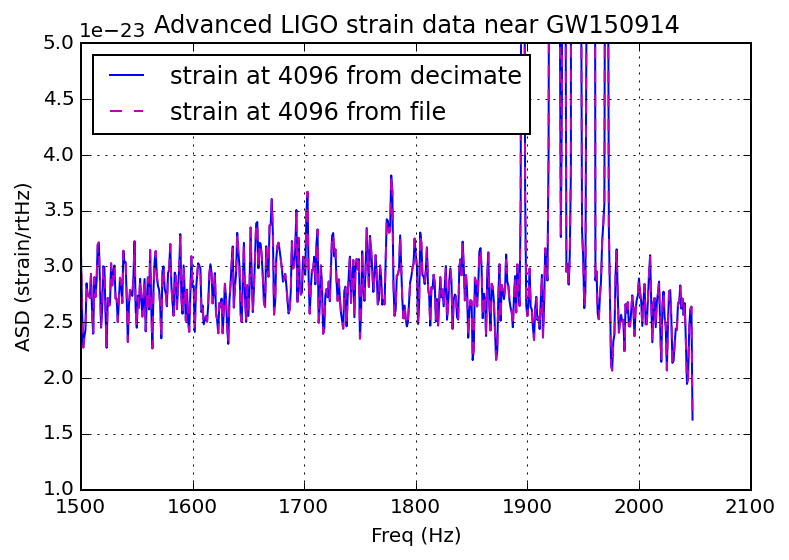

In [19]:
# Now downsample the 16384 Hz data and compare with the 4096 Hz data

factor = 4
numtaps = 61
strain_4new = signal.decimate(strain_16, factor, numtaps-1,ftype='fir')

fs = 4096
NFFT = 1*fs
Pxx_4new, freqs_4 = mlab.psd(strain_4new, Fs = fs, NFFT = NFFT)

fmin = 1500
fmax = 2100

plt.figure()
plt.plot(freqs_4, np.sqrt(Pxx_4new),'b',label='strain at 4096 from decimate')
plt.plot(freqs_4,  np.sqrt(Pxx_4), 'm--',label='strain at 4096 from file')
plt.axis([fmin, fmax, 1e-23, 5e-23])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper left')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_H1_ASD_4096_zoom.png')


The two traces are on top of each other, as expected. That's how we made the downsampled data in the first place.

From the above, we learn exactly how LOSC downsamples the strain time series from 16384 Hz to 4096 Hz 
(ie, using scipy.decimate), and that if you are interested in frequency content above ~ 1700 Hz,
use the 16384 Hz sample rate data instead.

## Data segments

As mentioned above, LIGO strain time series data has gaps (filled with NaNs) when the detectors are not taking valid ("science quality") data. Analyzing these data requires the user to loop over "segments" of valid data stretches.

For this GW150914 data release, the data have no gaps. Let's verify this, using the L1 data file containing 32 seconds of data sampled at 4096 Hz.

You are welcome to repeat this with H1 data, with files containing 4096 seconds of data, and with data sampled at 16384 Hz. All of the relevant files are listed near the top of this tutorial.

In [20]:
# read in the data at 4096 Hz:
fn = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
strain, time, chan_dict = rl.loaddata(fn, 'H1')

print "Contents of all the key, value pairs in chan_dict"
for keys,values in chan_dict.items():
    print(keys)
    print(values)

print "We see that all keys have 32 seconds of '1', meaning the data pass all data quality flags"
print "and have no HW injections, except there are CW injections in L1."
print " "
print 'Total number of non-NaNs in these data = ',np.sum(~np.isnan(strain))
print 'GPS start, GPS stop and length of  all data in this file = ',time[0], time[-1],len(strain)

# select the level of data quality; default is "DATA" but "CBC_CAT3" is a conservative choice:
DQflag = 'CBC_CAT3'
# readligo.py method for computing segments (start and stop times with continuous valid data):
segment_list = rl.dq_channel_to_seglist(chan_dict[DQflag])
print 'Number of segments with DQflag',DQflag,' = ',len(segment_list)

# loop over seconds and print out start, stop and length:
iseg = 0
for segment in segment_list:
    time_seg = time[segment]
    seg_strain = strain[segment]
    print 'GPS start, GPS stop and length of segment',iseg, \
        'in this file = ',time_seg[0], time_seg[-1], len(seg_strain)
    iseg = iseg+1
    # here is where you would insert code to analyze the data in this segment.
    
# now look at segments with no CBC hardware injections:
DQflag = 'NO_CBC_HW_INJ'
segment_list = rl.dq_channel_to_seglist(chan_dict['NO_CBC_HW_INJ'])
print 'Number of segments with DQflag',DQflag,' = ',len(segment_list)
iseg = 0
for segment in segment_list:
    time_seg = time[segment]
    seg_strain = strain[segment]
    print 'GPS start, GPS stop and length of segment',iseg, \
        'in this file = ',time_seg[0], time_seg[-1], len(seg_strain)
    iseg = iseg+1


Contents of all the key, value pairs in chan_dict
NO_BURST_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_CBC_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DEFAULT
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_CW_HW_INJ
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
NO_STOCH_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_DETCHAR_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DATA
[1 1 1 1